# Code For Chemistry

In [11]:

import importlib
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from copy import deepcopy
from decimal import Decimal, getcontext, DecimalException
import math
from scipy.optimize import curve_fit
import sympy as sp
from matplotlib.font_manager import FontProperties


In [ ]:

#enhanced binary search intersection robust version for large numbers
#default tolerance is 1e-5
def binary_search_intersection(func1, func2, low, high, tolerance=1e-7, max_iterations=10000) -> float:
    """
    Find the intersection of two functions f1(x)=func1(x) and f2(x)=func2(x) (i.e. where f1(x)==f2(x))
    using a robust binary search approach that can handle enormous numbers.
    
    This version avoids evaluating huge numbers directly by using a "safe" evaluation routine.
    It assumes that on the search interval the functions are positive (so logarithms make sense)
    and that the difference f(x)=func1(x)-func2(x) is monotonic.
    
    Args:
        func1, func2: The two functions.
        low, high: The endpoints of the search interval.
        tolerance: The acceptable error for f(x) (or its logarithmic version).
        max_iterations: Maximum iterations to try.
    
    Returns:
        The x-value where the functions intersect, or None if no intersection was found.
    """
    # Use high precision for interval arithmetic.
    getcontext().prec = 100
    low = Decimal(str(low))
    high = Decimal(str(high))
    tol = Decimal(str(tolerance))
    
    def safe_f(x_dec: Decimal) -> float:
        """
        Evaluate f(x)=func1(x)-func2(x) in a way that avoids overflow.
        
        If one (or both) function evaluations results in a value that overflows (or is infinite),
        we assign float('inf') to that value. In the case that both are infinite (e.g. for enormous x)
        we instead compare their logarithms.
        
        Returns:
            A float representing the difference, or the difference of logarithms if needed.
        """
        x = float(x_dec)
        try:
            v1 = func1(x)
        except OverflowError:
            v1 = float('inf')
        try:
            v2 = func2(x)
        except OverflowError:
            v2 = float('inf')
            
        # If either function evaluates to infinity (or a value that compares as such), we replace it.
        if math.isinf(v1) or math.isinf(v2):
            # If both are infinite and positive, try to compare their logarithms.
            if v1 > 0 and v2 > 0 and math.isinf(v1) and math.isinf(v2):
                try:
                    log_v1 = math.log(func1(x))
                except (OverflowError, ValueError):
                    log_v1 = float('inf')
                try:
                    log_v2 = math.log(func2(x))
                except (OverflowError, ValueError):
                    log_v2 = float('inf')
                return log_v1 - log_v2
            # Otherwise, if only one is infinite, the difference will have the sign of the finite number.
            # (If v1 is infinite and v2 is not, f(x) is positive; if v2 is infinite, f(x) is negative.)
            if math.isinf(v1) and not math.isinf(v2):
                return float('inf')
            if math.isinf(v2) and not math.isinf(v1):
                return -float('inf')
        return v1 - v2

    # Evaluate at the endpoints.
    try:
        f_low = safe_f(low)
        f_high = safe_f(high)
    except (OverflowError, ValueError, DecimalException) as e:
        print("Error evaluating function at endpoints:", e)
        return None

    # Check that f(low) and f(high) bracket a sign change.
    if f_low * f_high > 0:
        print("No sign change in f(x) over the interval; intersection not guaranteed.")
        return None

    for i in range(max_iterations):
        mid = (low + high) / 2
        f_mid = safe_f(mid)

        # If we are close enough, return.
        if abs(f_mid) < float(tol):
            return float(mid)

        # Decide which side of the interval contains the sign change.
        if f_low * f_mid < 0:
            high = mid
            f_high = f_mid
        else:
            low = mid
            f_low = f_mid

        # If the interval has shrunk sufficiently, exit.
        if abs(high - low) < tol:
            return float(mid)

    print(f"No intersection found within {max_iterations} iterations")
    return None

# #constants in different format 
fidelity_improvement_rate = .28
gate_speed_improvement_rate = .14
classical_speed_init = 1/(1.5*1e9) #
superconducting_gate_speed_init = 1e-6 #(1/(1.5*1e9))*(10**3.78) # seconds #overhead taken from quantum economic advantage calculator 
initial_error = 10**(-2.5)
classical_speed_improvement_rate = 0.3 #moore's law improvement 
number_of_processors = 1e8 #processor overehead done from calculations for GPUs
# time_upper_limt = 3.14*1e7 # 1-year of seconds
connectivity_penalty_exponent = 0.0 #connectivity penalty for physical to logical qubit ratio in this range. default no asymptotic connectivity penality 
time_upper_limit = (3.14*1e7)/12 # 1 month computation time 
scode_init_speed_overhead = 1e2 # slowdown overhead from Choi, Neil, and Moses
alg_overhead_qubit = 1e1# algorithm overhead in logical qubits 
alg_overhead_qspeed = 1e0 # algorithm speed overhead based on constants this is exclusivly for quantum algorithm
classical_alg_overhead = 1e0
MAX_PROBLEM_SIZE = 1e50
MIN_YEAR = 2025
MAX_YEAR = 2050





#default quantum and classical runtime if not specified
classical_runtime = "n**3"
quantum_runtime = "n"

IBM_ROADMAP = {
    2020: 27,
    2022: 127,
    2024: 133,
    2025: 156,
    2028: 1092,
}
GOOGLE_ROADMAP = {
    2019: 53,
    2024: 105,
}
PERCENTILE_95_ROADMAP = {
   2025:1662,
   2030: 15660,
}
SOTA_ROADMAP = {
    2025:1959,
    2030:24352,
}


default_roadmap = IBM_ROADMAP

#gives the physical to logical overhead based on the surface code formula 
def surface_code_formula(pP:float)->float:
    pL = 1e-18
    pth = 1e-2
    numerator = 4 * math.log(math.sqrt(10 * pP / pL))
    denominator = math.log(pth / pP)
    fraction = numerator / denominator
    f_QEC = (fraction + 1) ** -2
    return f_QEC**-1
# 


# legacy function will try to remove later 
def problem_size_qubit_feasible(roadmap:dict)->callable:
    # fit exponential to roadmap 
    years = np.array(list(roadmap.keys()))
    qubits = np.array(list(roadmap.values()))
    min_year = min(years)
    # initial gues 
    p0 = [min(qubits), 0.5, 0]
    # fit an exponential curve to the data
    def exp_func(x, a, b, c):
        return a * np.exp(b * (x-min_year)) + c
    try:
        popt, _ = curve_fit(
            exp_func, years, qubits, p0=p0, bounds=([0, -2, -1000], [10000, 2, 1000])
        )
    except RuntimeError:
        # print(f"Fitting failed for {label}")
        return None
    # get the function
    def func(year):
        surf_overhead = surface_code_formula(initial_error*(1-fidelity_improvement_rate)**(year-2025))
        # this would be exponential depending on qubit to problem size
        return min(exp_func(year, *popt)/(surf_overhead*alg_overhead_qubit), MAX_PROBLEM_SIZE)
    return func

def problem_size_qubit_feasible_year(roadmap:dict, year:int, alg_overhead:float=1)->float:
    
    # fit exponential to roadmap 
    years = np.array(list(roadmap.keys()))
    qubits = np.array(list(roadmap.values()))
    min_year = min(years)
    # initial gues 
    p0 = [min(qubits), 0.5, 0]
    # fit an exponential curve to the data
    def exp_func(x, a, b, c):
        return a * np.exp(b * (x-min_year)) + c
    try:
        popt, _ = curve_fit(
            exp_func, years, qubits, p0=p0, bounds=([0, -2, -1000], [10000, 2, 1000])
        )
    except RuntimeError:
        # print(f"Fitting failed for {label}")
        return None
    # get the function
    def func(year):
        surf_overhead = surface_code_formula(initial_error*(1-fidelity_improvement_rate)**(year-2025))
        # this would be exponential depending on qubit to problem size
        return min(exp_func(year, *popt)/(surf_overhead*alg_overhead_qubit), MAX_PROBLEM_SIZE)
    return func(year)



# quantum speed per operation function 
def quantum_seconds_per_operation(year):
    gate_speed = superconducting_gate_speed_init * (1-gate_speed_improvement_rate)**(year-2025)
    #with error correction 
    fidelity_year = initial_error*(1-fidelity_improvement_rate)**(year-2025)
    proportional_change = (surface_code_formula(fidelity_year))/surface_code_formula(initial_error)
    return gate_speed*scode_init_speed_overhead*proportional_change**(1.5)


# seconds per effective operation ie here we factor in parallelism
def classical_seconds_per_operation(year):
    # just dividing by number of processors here for now to simplify things
    return 1e-9 *(1-classical_speed_improvement_rate)**(year-2025)/number_of_processors


# maximum problem size that can be solved on a quantum computer in a given amount of time at a given year
def find_largest_problem_size(runtime_string, year:int, quantum=True, qadv_only=False, roadmap:dict=default_roadmap, stagnation_year=2200, time_upper_limit=time_upper_limit)->float:
    # Constants
    try:
        # Convert string expression to lambda function
        n = sp.Symbol("n")
        expr = sp.sympify(runtime_string)
        expr = expr * n**connectivity_penalty_exponent * alg_overhead_qspeed
        # Apply connectivity penalty to the runtime
        runtime_func = sp.lambdify(n, expr)

        if quantum:
            quantum_total = lambda size: quantum_seconds_per_operation(year)*runtime_func(size)
            def quantum_limit(x):
                return time_upper_limit # number of seconds in a year
                # return q_ops_second_dollar

            qadv = binary_search_intersection(
                quantum_total, quantum_limit, low=1.0, high=1e50
            )

            feasability_qubit_func  = problem_size_qubit_feasible(roadmap)
            size_feasible = feasability_qubit_func(year)


            # Handle the case where size_feasible is None
            if size_feasible is None:
                print(f"No feasible size found for year {year}. Returning infinity.")
                return float("inf")  # Return infinity if no feasible size is found
            if not qadv_only:
                return min(qadv, size_feasible)
            else:
                return qadv

        else:

            def classical_cost(x):
                if year < stagnation_year:  
                    return classical_seconds_per_operation(year)*runtime_func(x)
                else:
                    return classical_seconds_per_operation(stagnation_year)*runtime_func(x)

            def classical_limit(x):
                return time_upper_limit
                # return ops_second_dollar

            return binary_search_intersection(
                classical_cost, classical_limit, low=1.0, high=1e50
            )

    except Exception as e:
        print(f"Error in function evaluation: {e}")
        return None



def quantum_advantage_size_by_year(year, classical_runtime_string:str, quantum_runtime_string:str)->float:
    n = sp.symbols("n")
    class_expr = sp.sympify(classical_runtime_string)
    class_expr = class_expr * classical_seconds_per_operation(year) * classical_alg_overhead
    classical_runtime_func = sp.lambdify(n, class_expr)

    quant_expr = sp.sympify(quantum_runtime_string)
    quant_expr = quant_expr * n**connectivity_penalty_exponent * alg_overhead_qspeed
    quant_expr = quant_expr * quantum_seconds_per_operation(year)
    quantum_runtime_func = sp.lambdify(n, quant_expr)

    # Find intersection using the original string expressions
    return binary_search_intersection(classical_runtime_func,quantum_runtime_func,1.0,1e50)


#this is the intersection of quantum advantage size by year and quantum problem size qubit feasible by year 
def generalized_qea(classical_runtime_string:str, quantum_runtime_string:str)->float:
    return binary_search_intersection(
        lambda x: quantum_advantage_size_by_year(x, classical_runtime_string, quantum_runtime_string),
        lambda x:find_largest_problem_size(quantum_runtime_string, x, quantum=True),
        MIN_YEAR,
        MAX_YEAR
    )



In [13]:
# # Setup common variables and constants to avoid order dependency issues
# # These should be defined early to prevent "variable not defined" errors

# # Define time range for analysis
# MIN_YEAR = 2025
# MAX_YEAR = 2050
# years = np.arange(MIN_YEAR, MAX_YEAR, .2)

# # Set algorithm overheads
# alg_overhead_qspeed = 1e0
# alg_overhead_qubit = 1e1
# classical_alg_overhead = 1e0

# # Define runtime expressions
# classical_runtime_mp2 = "n**5"
# classical_runtime = "n**6"
# quantum_runtime = "1e3*n**3"
# classical_runtime_ccsdpt = "n**8"
# classical_runtime_fci = "4**n"

# print("Common variables initialized successfully!")


In [14]:
# surface_code_formula(10**-2.5)
# classical_runtime = "n**6"
# quantum_runtime = "1e3*n**2"
# # Calculate the quantum advantage size for each year
# classical_alg_overhead = 1e4
# print(quantum_advantage_size_by_year(2027, classical_runtime, quantum_runtime))

In [15]:
# graph suface code overhead over time
years = np.arange(2025, 2050)
surface_code_overhead_init = surface_code_formula(initial_error*fidelity_improvement_rate**(2025-2025))
surface_code_overhead_list = [(surface_code_formula(initial_error*fidelity_improvement_rate**(year-2025))/surface_code_formula(initial_error))**1.5 for year in years]
plt.figure(figsize=(10, 6))
plt.plot(years, surface_code_overhead_list, marker='o', linestyle='-', color='b', label='Surface Code Overhead')
plt.xlabel('Year')
plt.yscale('log')
plt.ylabel('Surface Code Overhead')
plt.title('Surface Code Overhead by Year')
plt.grid(True)
plt.legend()
plt.show()
print(surface_code_overhead_list[0])
print(surface_code_formula(initial_error*(1-fidelity_improvement_rate)**(2025-2025)))/surface_code_formula(initial_error))



SyntaxError: unmatched ')' (1678397751.py, line 15)

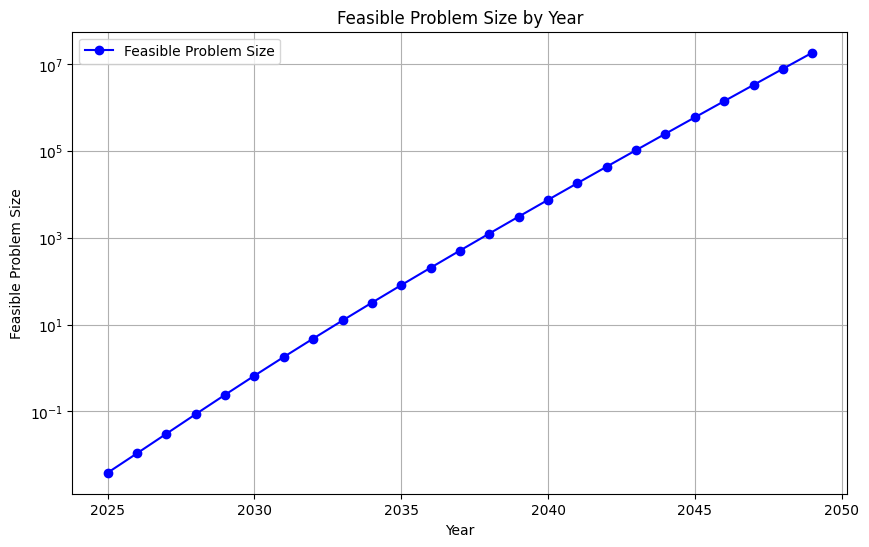

In [16]:
#graph problem_size_qubit_feasible
years = np.arange(2025, 2050)
feasible_sizes = [problem_size_qubit_feasible(IBM_ROADMAP)(year) for year in years]
plt.figure(figsize=(10, 6))
plt.plot(years, feasible_sizes, marker='o', linestyle='-', color='b', label='Feasible Problem Size')
plt.xlabel('Year')
plt.ylabel('Feasible Problem Size')

plt.title('Feasible Problem Size by Year')
plt.grid(True)
plt.legend()
plt.yscale('log')

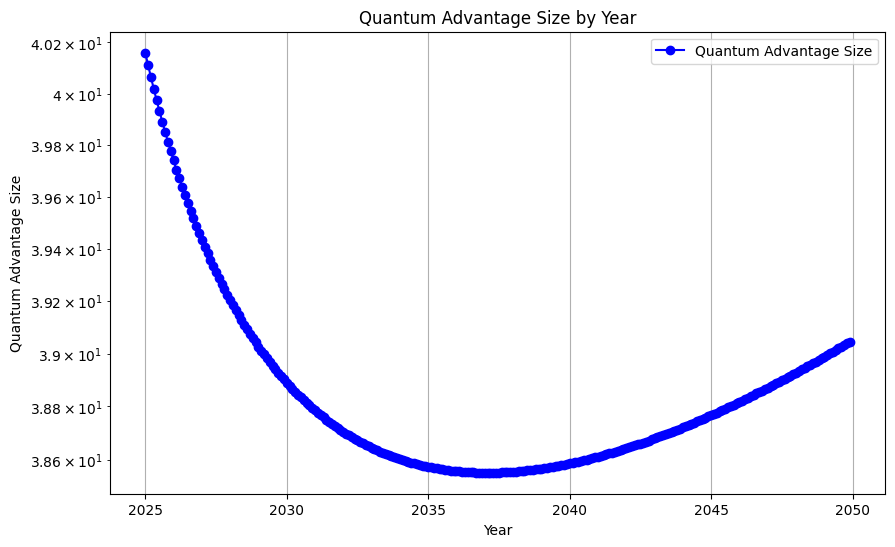

In [17]:

# Define the range of years
# years = range(2025, 2050)
years = np.arange(2025, 2050, 0.1)
classical_alg_overhead = 1e-5
classical_runtime = "1.07*4**n"
quantum_runtime = "10**(3)*n**2"
# Calculate the quantum advantage size for each year
quantum_advantage_sizes = [quantum_advantage_size_by_year(year, classical_runtime, quantum_runtime) for year in years]

# Filter out None values for plotting
filtered_years = [year for year, size in zip(years, quantum_advantage_sizes) if size is not None]
filtered_sizes = [size for size in quantum_advantage_sizes if size is not None]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(filtered_years, filtered_sizes, marker='o', linestyle='-', color='b', label='Quantum Advantage Size')
plt.xlabel('Year')
plt.ylabel('Quantum Advantage Size')
plt.title('Quantum Advantage Size by Year')
plt.grid(True)
plt.legend()
plt.yscale('log')
plt.show()

# Google_roadmap = {
#     2019: 54,
#     2023: 100,
#     2025: 1000,
# }

# Graph of Chemistry 

In [18]:
surface_code_formula(1e-4)

255.99999999999994

In [19]:
# test find largest problem size
runtime_string = "n**8"
year = 2030
# find_largest_problem_size(runtime_expr, year, quantum=True, qadv_only=False, stagnation_year=2200, time_upper_limit=6*1e5)
# binary_search_intersection(lambda x: x**8, lambda x: 6*1e5, 1.0, 1e50)

binary_search_intersection(lambda x: x**8, lambda x: 6*1e5, 1.0, 1e50)


5.275564094923295

# Descriptive Version for Paper 

No sign change in f(x) over the interval; intersection not guaranteed.
Error in function evaluation: unsupported operand type(s) for -: 'NoneType' and 'int'
the intersection year of fci and quantum max computable problem size is  2034.0243414975703
125 quantum_economic_advantages_fci
125 quantum_problem_sizes


/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_78503/2910807245.py:100: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(intersection_year_fci, intersection_value_fci, 'ro', color="black")


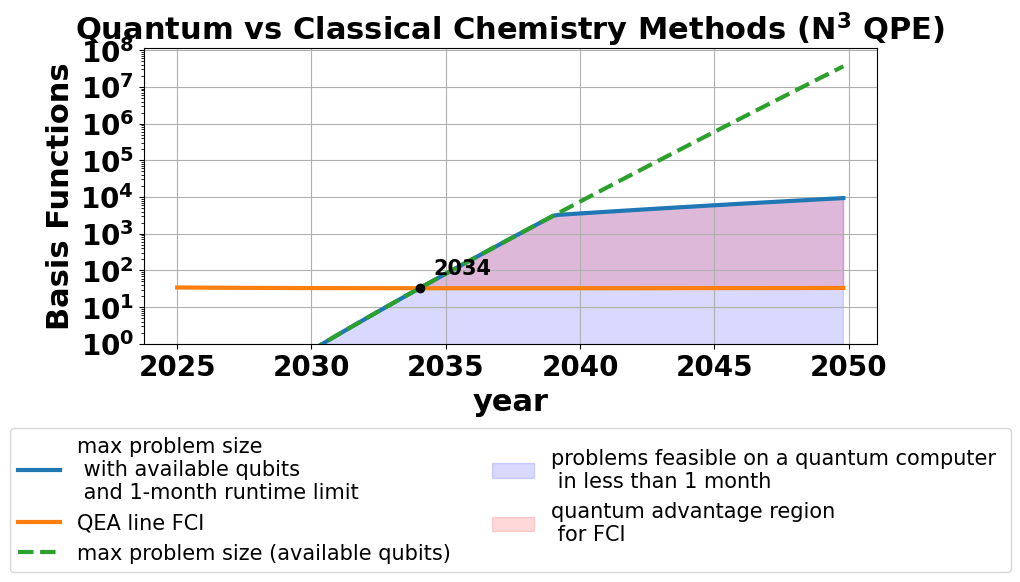

In [61]:
#bolder version for poster 

#add moller plesset
classical_runtime_mp2 = "n**5"
classical_runtime = "n**6"
quantum_runtime = "1e3*n**3"
classical_runtime_ccsdpt = "n**8"
classical_runtime_fci = "4**n"


alg_overhead_qspeed = 1e0
alg_overhead_qubit = 1e1
classical_alg_overhead = 1e0

# Define years first before using it
years = np.arange(MIN_YEAR, MAX_YEAR, .2)

#set figsize
plt.figure(figsize=(10, 7))
roadmap = default_roadmap
qubit_feasible_line= [problem_size_qubit_feasible_year(roadmap, year) for year in years]


# graph largeset problem size vs year for grovers algorithms
quantum_problem_sizes = [
    find_largest_problem_size(quantum_runtime, year, quantum=True) for year in years
]
# print(classical_problem_sizes_ccsdpt)

# quantum_economic_advantages_ccsd = [
#     quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime) for year in years
# ]
quantum_economic_advantages_ccsdpt = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_ccsdpt, quantum_runtime_string=quantum_runtime) for year in years
]
quantum_economic_advantages_fci = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_fci, quantum_runtime_string=quantum_runtime) for year in years
]

# quantum_economic_advantages_mp2 = [
#     quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_mp2, quantum_runtime_string=quantum_runtime) for year in years
# ]
quantum_advantage_size_by_year_list= [
quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime) for year in years
]


def find_largest_problem_size_func(year):
    return find_largest_problem_size(quantum_runtime, year, quantum=True)

def quantum_advantage_size_by_year_func(year):
    return quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime)
# Find the intersection year using binary search
intersection_year = binary_search_intersection(find_largest_problem_size_func, quantum_advantage_size_by_year_func, MIN_YEAR, MAX_YEAR)


# Find the intersection value
intersection_value = find_largest_problem_size(quantum_runtime, intersection_year, quantum=True)
#====================================================================================================

#plotting code 
# plt.figure(figsize=(10, 6))
#plotting code 
plt.plot(years, quantum_problem_sizes, label="max problem size \n with available qubits \n and 1-month runtime limit", linewidth=3)
# plt.plot(years, quantum_economic_advantages_ccsd, label="quantum economic advantage ccsd", linewidth=3)
# plt.plot(years, quantum_economic_advantages_ccsdpt, label="quantum economic advantage ccsdpt", linewidth=3)
plt.plot(years, quantum_economic_advantages_fci, label="QEA line FCI", linewidth=3)
# plt.plot(years, quantum_economic_advantages_mp2, label="quantum economic advantage mp2", linewidth=3)
plt.plot(years, qubit_feasible_line, label="max problem size (available qubits)", linewidth=3, linestyle='--')


# plt.plot(years, classical_problem_sizes_ccsdpt, label="ccsdpt max computable problem size (1-week)", linewidth=3)
plt.ylabel("Basis Functions", fontsize=22, fontweight='bold')
plt.xlabel("year", fontsize=22, fontweight='bold')
tick_positions = np.logspace(0, 50, num=10, base=10)
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
plt.yscale("log")
plt.title("Quantum vs Classical Chemistry Methods ($\mathbf{N^3}$ QPE)", fontsize=22, fontweight='bold')
plt.grid() 
#move the legend to the upper right


# Adjust layout to prevent text cutoff

#====================================================================
# Find intersection between quantum max computable problem size and quantum economic advantage fci
intersection_year_fci = binary_search_intersection(
    find_largest_problem_size_func,
    lambda year: quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_fci, quantum_runtime_string=quantum_runtime),
    2025, 2050
)
print("the intersection year of fci and quantum max computable problem size is ", intersection_year_fci)

# Only plot if intersection was found
if intersection_year_fci is not None:
    intersection_value_fci = find_largest_problem_size(quantum_runtime, intersection_year_fci, quantum=True)
    
    # Plot the intersection point
    plt.plot(intersection_year_fci, intersection_value_fci, 'ro', color="black")
    plt.annotate(f'{round(intersection_year_fci)}',
                xy=(intersection_year_fci, intersection_value_fci),
                xytext=(10, 10), textcoords='offset points', fontsize=15, fontweight='bold')
else:
    print("No intersection found for FCI within the specified range")

#same as above but for ccsdpt


# intersection_year_ccsdpt = binary_search_intersection(
#     find_largest_problem_size_func,
#     lambda year: quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_ccsdpt, quantum_runtime_string=quantum_runtime),
#     MIN_YEAR, MAX_YEAR
# )
# print("the intersection year for ccsdpt is ", intersection_year_ccsdpt)
# intersection_value_ccsdpt = find_largest_problem_size(quantum_runtime, intersection_year_ccsdpt, quantum=True)
# plt.plot(intersection_year_ccsdpt, intersection_value_ccsdpt, 'ro', color="black")
# plt.annotate(f'{round(intersection_year_ccsdpt)}',
#             xy=(intersection_year_ccsdpt, intersection_value_ccsdpt),
#             xytext=(10, 10), textcoords='offset points', fontsize=15, fontweight='bold')


plt.ylim(1e0)

plt.fill_between(years, 0, quantum_problem_sizes,
                    color='blue', alpha=0.15, label='problems feasible on a quantum computer \n in less than 1 month')


print(len(quantum_economic_advantages_fci), "quantum_economic_advantages_fci")
print(len(quantum_problem_sizes), "quantum_problem_sizes")
plt.fill_between(years, quantum_economic_advantages_fci, quantum_problem_sizes,
                 color='red', alpha=0.15, label='quantum advantage region \n for FCI',
                 where=(np.array(quantum_problem_sizes) >= np.array(quantum_economic_advantages_fci)))



plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=15)

plt.tight_layout(rect=[0, 0, 1, 0.95], pad=1.5)  # Add padding and adjust height
plt.savefig("Figures/generalized_qea_model.png", bbox_inches='tight', dpi=300)  # Use bbox_inches to


# N^2 QPE Quantum Advantage Lines

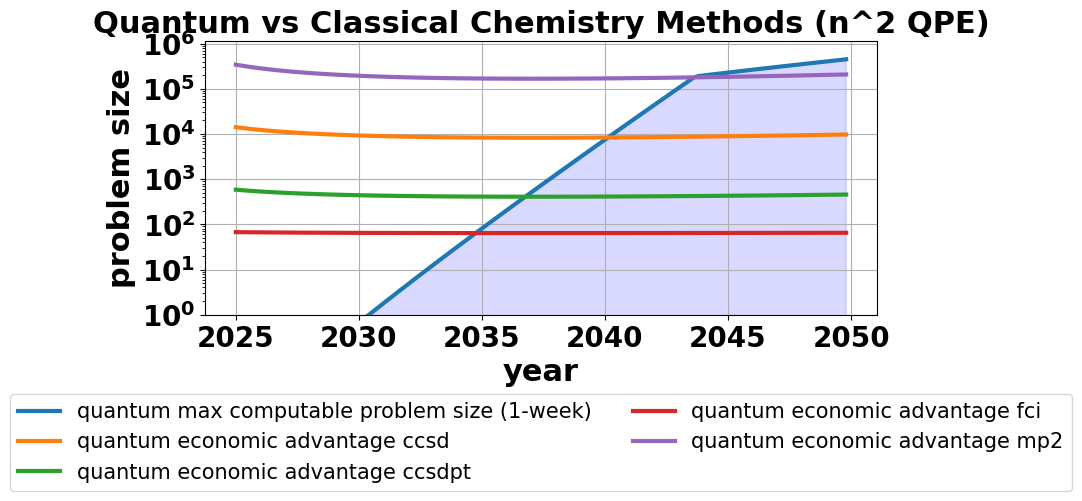

In [ ]:
#bolder version for poster 
classical_runtime = "n**6"
quantum_runtime = "1e3*n**2"
classical_runtime_ccsdpt = "n**8"
classical_runtime_fci = "2**n"
classical_runtime_mp2 = "n**5"

# graph largeset problem size vs year for grovers algorithms
years = np.arange(2025, 2050, .2)
quantum_problem_sizes = [
    find_largest_problem_size(quantum_runtime, year, quantum=True) for year in years
]
# print(classical_problem_sizes_ccsdpt)

quantum_economic_advantages_ccsd = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime) for year in years
]
quantum_economic_advantages_ccsdpt = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_ccsdpt, quantum_runtime_string=quantum_runtime) for year in years
]
quantum_economic_advantages_fci = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_fci, quantum_runtime_string=quantum_runtime) for year in years
]
quantum_economic_advantages_mp2 = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_mp2, quantum_runtime_string=quantum_runtime) for year in years
]
quantum_advantage_size_by_year_list= [
quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime) for year in years
]

def find_largest_problem_size_func(year):
    return find_largest_problem_size(quantum_runtime, year, quantum=True)

def quantum_advantage_size_by_year_func(year):
    return quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime)
# Find the intersection year using binary search
intersection_year = binary_search_intersection(find_largest_problem_size_func, quantum_advantage_size_by_year_func, 2025, 2050)

# Find the intersection value
intersection_value = find_largest_problem_size(quantum_runtime, intersection_year, quantum=True)
#====================================================================================================

#plotting code 
plt.figure(figsize=(10, 6))
#plotting code 
plt.plot(years, quantum_problem_sizes, label="quantum max computable problem size (1-week)", linewidth=3)
plt.plot(years, quantum_economic_advantages_ccsd, label="quantum economic advantage ccsd", linewidth=3)
plt.plot(years, quantum_economic_advantages_ccsdpt, label="quantum economic advantage ccsdpt", linewidth=3)
plt.plot(years, quantum_economic_advantages_fci, label="quantum economic advantage fci", linewidth=3)
plt.plot(years, quantum_economic_advantages_mp2, label="quantum economic advantage mp2", linewidth=3)
# plt.plot(years, classical_problem_sizes_ccsd, label="ccsd max computable problem size (1-week)", linewidth=3)
# plt.plot(years, classical_problem_sizes_stagnation, label="classical stagnation")
# plt.plot(years, quantum_advantage_size_by_year_list, label="quantum economic advantage", linewidth=3)

# plt.plot(years, classical_problem_sizes_ccsdpt, label="ccsdpt max computable problem size (1-week)", linewidth=3)
plt.ylabel("problem size", fontsize=22, fontweight='bold')
plt.xlabel("year", fontsize=22, fontweight='bold')
tick_positions = np.logspace(0, 50, num=10, base=10)
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
plt.yscale("log")
plt.title("Quantum vs Classical Chemistry Methods (n^2 QPE)", fontsize=22, fontweight='bold')
plt.grid() 
#move the legend to the upper right
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=15)

plt.ylim(1e0)
# Find intersection between quantum problem sizes and quantum advantage size
# intersection_year, intersection_value = find_intersection_year(
#     years, 
#     quantum_problem_sizes,
#     quantum_advantage_size_by_year_list
# )

# plt.plot(intersection_year, intersection_value, 'ro', label='Intersection', color="black")
# intersection_year = int(round(intersection_year))
# plt.annotate(f'{intersection_year}',
#             xy=(intersection_year, intersection_value),
#             xytext=(10, 10), textcoords='offset points', fontsize=12)

# plt.fill_between(years, quantum_advantage_size_by_year_list, quantum_problem_sizes,
#                     where=(np.array(quantum_problem_sizes) >= np.array(quantum_advantage_size_by_year_list)),
#                     color='blue', alpha=0.15, label='Problems Feasible and Advantageous')
plt.fill_between(years, 0, quantum_problem_sizes,
                    color='blue', alpha=0.15, label='Problems with Quantum Economic Advantage')
# Adjust layout to prevent text cutoff
plt.tight_layout(rect=[0, 0, 1, 0.95], pad=1.5)  # Add padding and adjust height
plt.savefig("Figures/qea_chemistry_graph.png", bbox_inches='tight', dpi=300)  # Use bbox_inches to prevent cutoff

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -.22), ncol=2)

# plt.plot(intersection_year, intersection_value, 'ro', label='Intersection', color="black")
# intersection_year = int(round(intersection_year))
# plt.annotate(f'{intersection_year}',
#             xy=(intersection_year, intersection_value),
#             xytext=(10, 10), textcoords='offset points', fontsize=20, fontweight='bold')



# N^5 Analysis and Older Asymptotic Times

No sign change in f(x) over the interval; intersection not guaranteed.
Error in function evaluation: unsupported operand type(s) for -: 'NoneType' and 'int'


/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_78503/2646408083.py:92: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(intersection_year_fci_n3, intersection_value_fci_n3, 'ro', color="black")


No sign change in f(x) over the interval; intersection not guaranteed.
Error in function evaluation: unsupported operand type(s) for -: 'NoneType' and 'int'


ValueError: x, y, and format string must not be None

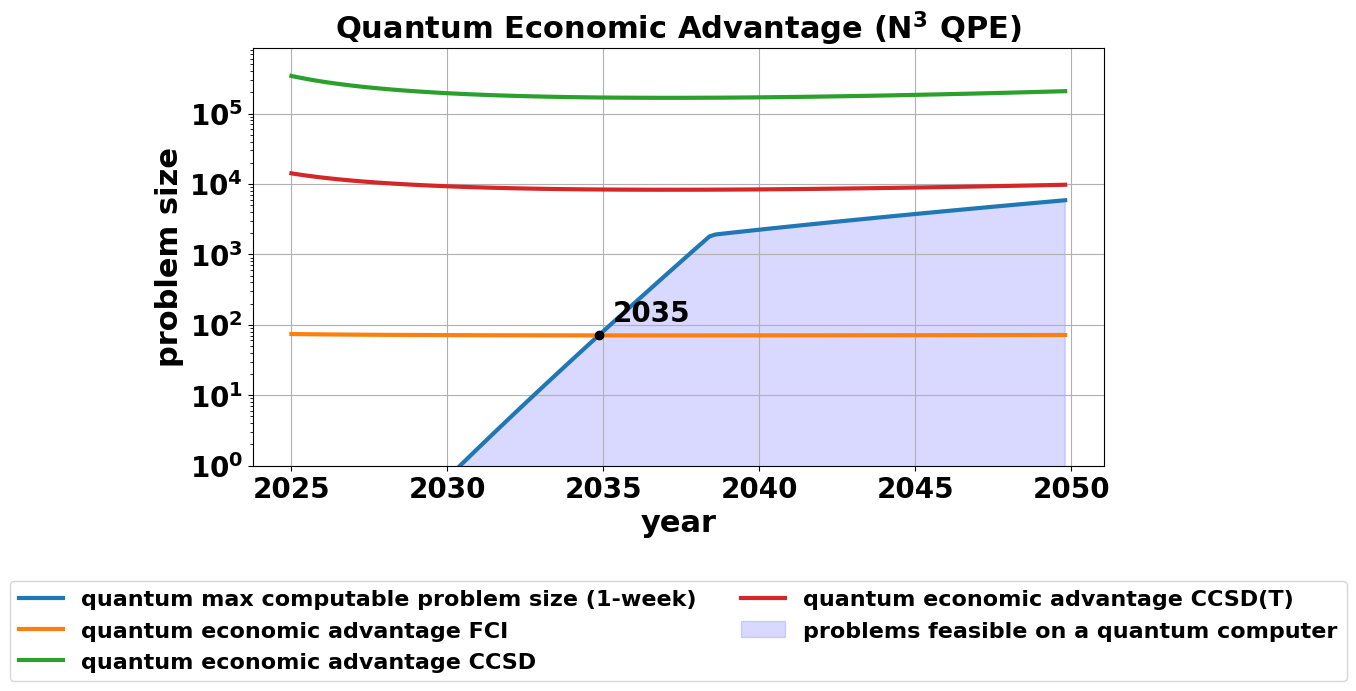

In [ ]:
alg_overhead_qubit = 1e1
alg_overhead_qspeed = 1e0
classical_alg_overhead_speed = 1e0

# bolder version for poster 
classical_runtime = "n**6"
quantum_runtime = "1e3*n**3"
classical_runtime_ccsdpt = "n**7"
classical_runtime_fci = "2**n"
# graph largeset problem size vs year for grovers algorithms
years = np.arange(2025, 2050, .2)
quantum_problem_sizes = [
    find_largest_problem_size(quantum_runtime, year, quantum=True) for year in years
]
# print(classical_problem_sizes_ccsdpt)

quantum_economic_advantages_ccsd = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime) for year in years
]
quantum_economic_advantages_ccsdpt = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_ccsdpt, quantum_runtime_string=quantum_runtime) for year in years
]

quantum_economic_advantages_fci = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_fci, quantum_runtime_string=quantum_runtime) for year in years
]
quantum_advantage_size_by_year_list= [
quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime) for year in years
]

def find_largest_problem_size_func(year):
    return find_largest_problem_size(quantum_runtime, year, quantum=True)

def quantum_advantage_size_by_year_func(year):
    return quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime)
# Find the intersection year using binary search
intersection_year = binary_search_intersection(find_largest_problem_size_func, quantum_advantage_size_by_year_func, 2025, 2050)

# Find the intersection value
intersection_value = find_largest_problem_size(quantum_runtime, intersection_year, quantum=True)
#====================================================================================================

#plotting code 
plt.figure(figsize=(10, 6))
#plotting code 
plt.plot(years, quantum_problem_sizes, label="quantum max computable problem size (1-week)", linewidth=3)
plt.plot(years, quantum_economic_advantages_fci, label="quantum economic advantage FCI", linewidth=3)
plt.plot(years, quantum_economic_advantages_ccsd, label="quantum economic advantage CCSD", linewidth=3)
plt.plot(years, quantum_economic_advantages_ccsdpt, label="quantum economic advantage CCSD(T)", linewidth=3)
# plt.plot(years, classical_problem_sizes_ccsd, label="ccsd max computable problem size (1-week)", linewidth=3)
# plt.plot(years, classical_problem_sizes_stagnation, label="classical stagnation")
# plt.plot(years, quantum_advantage_size_by_year_list, label="quantum economic advantage", linewidth=3)

# plt.plot(years, classical_problem_sizes_ccsdpt, label="ccsdpt max computable problem size (1-week)", linewidth=3)
plt.ylabel("problem size", fontsize=22, fontweight='bold')
plt.xlabel("year", fontsize=22, fontweight='bold')
tick_positions = np.logspace(0, 50, num=10, base=10)
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
plt.yscale("log")
plt.title("Quantum Economic Advantage ($\mathbf{N^3}$ QPE)", fontsize=22, fontweight='bold')
plt.grid()
#move the legend to the upper right


plt.ylim(1e0)
plt.fill_between(years, 0, quantum_problem_sizes,
                    color='blue', alpha=0.15, label='problems feasible on a quantum computer')
# Adjust layout to prevent text cutoff
plt.tight_layout(rect=[0, 0, 1, 0.95], pad=1.5)  # Add padding and adjust height


prop = {'size': 16, 'weight': 'bold'}
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2, prop=prop)






# Find intersection point for FCI with n^3 QPE
def quantum_advantage_size_by_year_func_fci_n3(year):
    return quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_fci, quantum_runtime_string=quantum_runtime)

# Find the intersection year using binary search for FCI
intersection_year_fci_n3 = binary_search_intersection(find_largest_problem_size_func_n3, quantum_advantage_size_by_year_func_fci_n3, 2025, 2050)

# Find the intersection value for FCI
intersection_value_fci_n3 = find_largest_problem_size(quantum_runtime, intersection_year_fci_n3, quantum=True)

# Plot the intersection point for FCI
plt.plot(intersection_year_fci_n3, intersection_value_fci_n3, 'ro', color="black")
plt.annotate(f'{int(round(intersection_year_fci_n3))}',
            xy=(intersection_year_fci_n3, intersection_value_fci_n3),
            xytext=(10, 10), textcoords='offset points', fontsize=20, fontweight='bold')


def quantum_economic_advantage_ccsdpt_n3(year):
    return quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_ccsdpt, quantum_runtime_string=quantum_runtime)

#plot intersection point for ccsdpt
intersection_year_ccsdpt_n3 = binary_search_intersection(find_largest_problem_size_func, quantum_economic_advantage_ccsdpt_n3, 2025, 2050)
intersection_value_ccsdpt_n3 = find_largest_problem_size(quantum_runtime, intersection_year_ccsdpt_n3, quantum=True)
plt.plot(intersection_year_ccsdpt_n3, intersection_value_ccsdpt_n3, 'ro', color="black")
plt.annotate(f'{int(round(intersection_year_ccsdpt_n3))}',
            xy=(intersection_year_ccsdpt_n3, intersection_value_ccsdpt_n3),
            xytext=(10, 10), textcoords='offset points', fontsize=20, fontweight='bold')

plt.savefig("Figures/n3_chemistry_graph.png", bbox_inches='tight', dpi=300)  # 

# All Plots as Subplots: ie the Triptic

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_78503/3589306980.py:70: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[0].plot(intersection_year_fci_n2, intersection_value_fci_n2, 'ro', color="black")
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_78503/3589306980.py:81: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[0].plot(intersection_year_ccsdpt_n2, intersection_value_ccsdpt_n2, 'ro', color="black")
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_78503/3589306980.py:93: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[0].plot(intersection_year_mp2_n2, intersection_value_mp2_n2, 'ro', color="black")
/var/fo

No sign change in f(x) over the interval; intersection not guaranteed.
Error in function evaluation: unsupported operand type(s) for -: 'NoneType' and 'int'


/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_78503/3589306980.py:171: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[1].plot(intersection_year_fci_n3, intersection_value_fci_n3, 'ro', color="black")
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_78503/3589306980.py:182: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[1].plot(intersection_year_ccsdpt_n3, intersection_value_ccsdpt_n3, 'ro', color="black")


No sign change in f(x) over the interval; intersection not guaranteed.
Error in function evaluation: unsupported operand type(s) for -: 'NoneType' and 'int'


/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_78503/3589306980.py:240: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[2].plot(intersection_year_fci_n5, intersection_value_fci_n5, 'ro', color="black")


No sign change in f(x) over the interval; intersection not guaranteed.


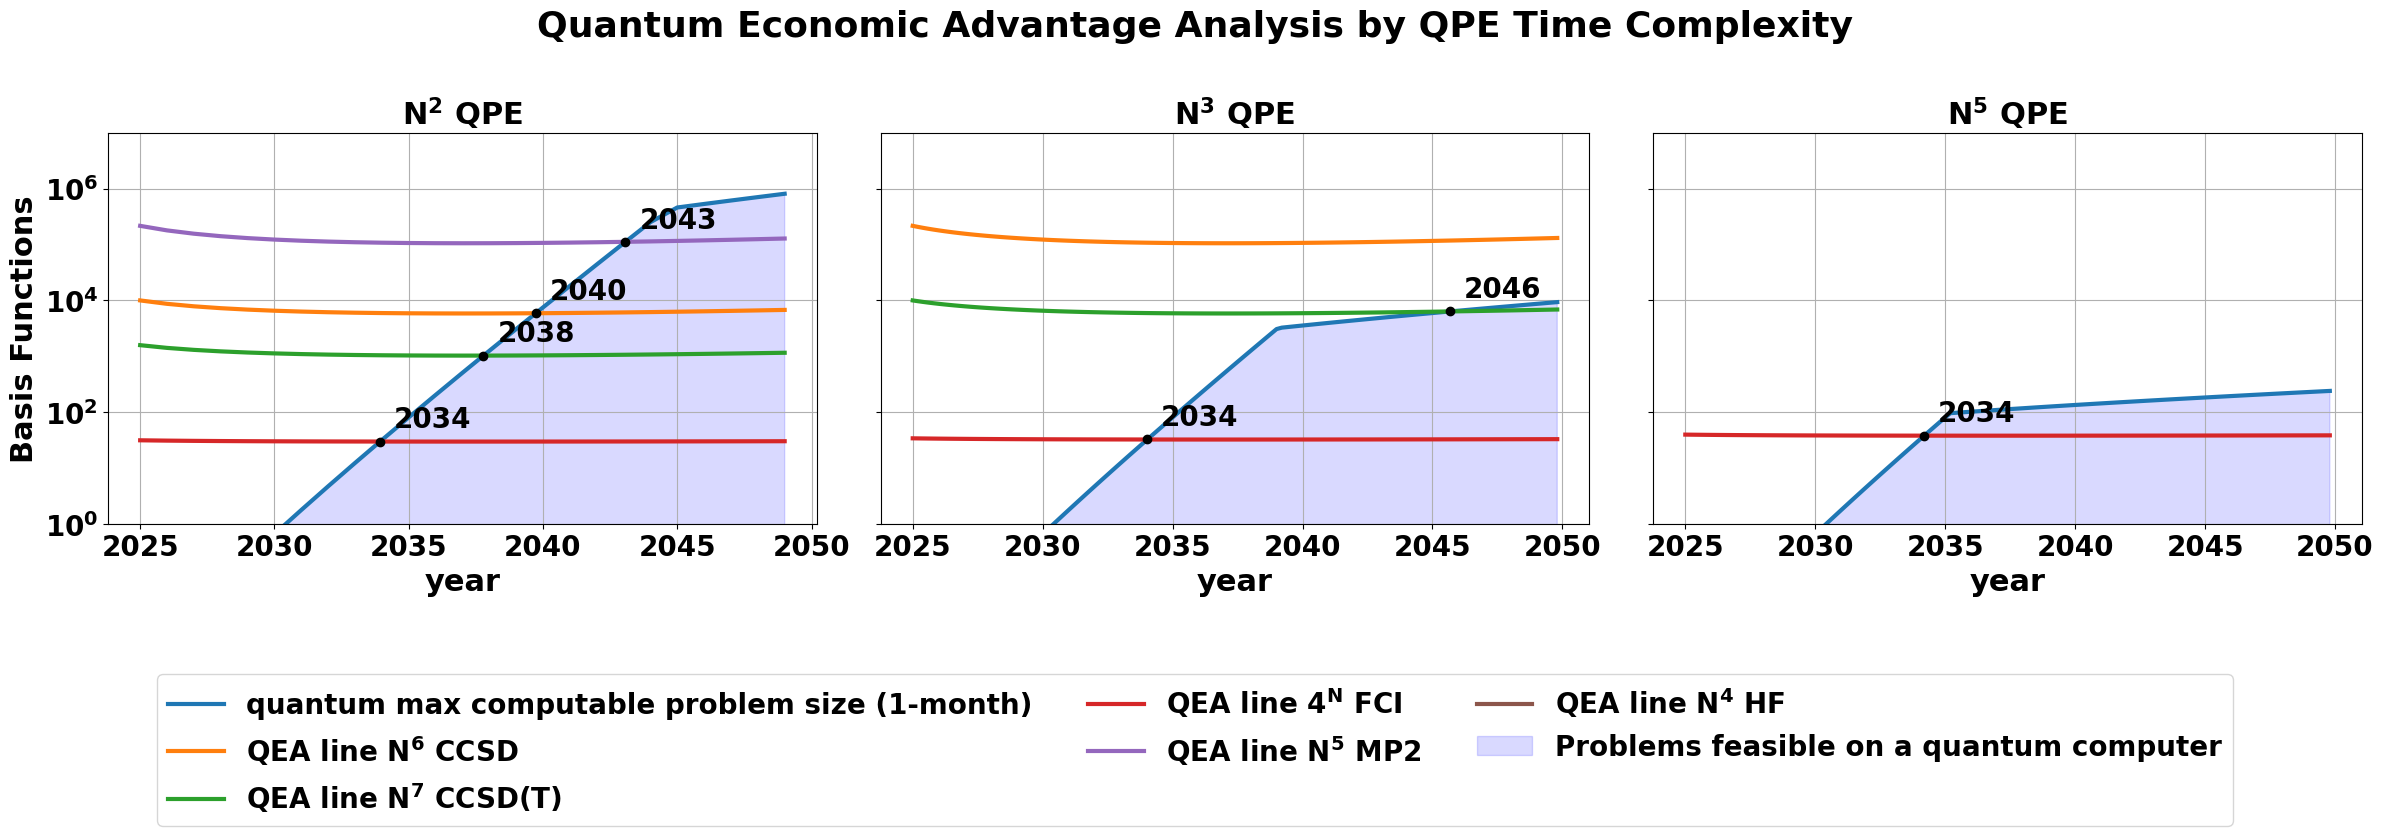

In [ ]:
# Create a figure with three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharey=True)
plt.ylim(top=1e7)

#constant adjustment 
alg_overhead_qspeed = 1e0
alg_overhead_qubit = 1e1
classical_alg_overhead = 1e0

# Second subplot - n^2 QPE
classical_runtime_hf = "n**4"
classical_runtime_ccsd = "n**6"
classical_runtime_mp2 = "n**5"
classical_runtime_ccsdpt = "n**7"
classical_runtime_fci = "4**n"
quantum_runtime = "1e3*n**2"


annotation_size = 20

quantum_problem_sizes_n2 = [
    find_largest_problem_size(quantum_runtime, year, quantum=True) for year in years
]
quantum_economic_advantages_hf_n2 = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_hf, quantum_runtime_string=quantum_runtime) for year in years
]

quantum_economic_advantages_ccsd_n2 = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_ccsd, quantum_runtime_string=quantum_runtime) for year in years
]
quantum_economic_advantages_ccsdpt_n2 = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_ccsdpt, quantum_runtime_string=quantum_runtime) for year in years
]
quantum_economic_advantages_fci_n2 = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_fci, quantum_runtime_string=quantum_runtime) for year in years
]
quantum_economic_advantages_mp2_n2 = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_mp2, quantum_runtime_string=quantum_runtime) for year in years
]

def find_largest_problem_size_func_n2(year):
    return find_largest_problem_size(quantum_runtime, year, quantum=True)

axes[0].plot(years, quantum_problem_sizes_n2, label="quantum max computable problem size (1-month)", linewidth=3)
axes[0].plot(years, quantum_economic_advantages_ccsd_n2, label=r"QEA line $\mathbf{N^6}$ CCSD", linewidth=3)
axes[0].plot(years, quantum_economic_advantages_ccsdpt_n2, label=r"QEA line $\mathbf{N^7}$ CCSD(T)", linewidth=3)
axes[0].plot(years, quantum_economic_advantages_fci_n2, label=r"QEA line $\mathbf{4^N}$ FCI", linewidth=3)
axes[0].plot(years, quantum_economic_advantages_mp2_n2, label=r"QEA line $\mathbf{N^5}$ MP2", linewidth=3)
axes[0].plot(years, quantum_economic_advantages_hf_n2, label=r"QEA line $\mathbf{N^4}$ HF", linewidth=3)

axes[0].set_xlabel("year", fontsize=22, fontweight='bold')
axes[0].tick_params(axis='both', which='major', labelsize=20)  # Removed invalid labelweight parameter
for label in axes[0].get_xticklabels() + axes[0].get_yticklabels():
    label.set_fontweight('bold')
axes[0].set_yscale("log")
axes[0].set_title(r"$\mathbf{N^2}$ QPE", fontsize=22, fontweight='bold')
axes[0].grid()
axes[0].set_ylim(1e0)

axes[0].fill_between(years, 0, quantum_problem_sizes_n2,
                   color='blue', alpha=0.15, label='Problems feasible on a quantum computer')

# Plot intersection points for n^2 QPE
intersection_year_fci_n2 = binary_search_intersection(
    find_largest_problem_size_func_n2,
    lambda year: quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_fci, quantum_runtime_string=quantum_runtime),
    2025, 2050
)
intersection_value_fci_n2 = find_largest_problem_size(quantum_runtime, intersection_year_fci_n2, quantum=True)
axes[0].plot(intersection_year_fci_n2, intersection_value_fci_n2, 'ro', color="black")
axes[0].annotate(f'{int(round(intersection_year_fci_n2))}',
               xy=(intersection_year_fci_n2, intersection_value_fci_n2),
               xytext=(10, 10), textcoords='offset points', fontsize=annotation_size, fontweight='bold')

intersection_year_ccsdpt_n2 = binary_search_intersection(
    find_largest_problem_size_func_n2,
    lambda year: quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_ccsdpt, quantum_runtime_string=quantum_runtime),
    2025, 2050
)
intersection_value_ccsdpt_n2 = find_largest_problem_size(quantum_runtime, intersection_year_ccsdpt_n2, quantum=True)
axes[0].plot(intersection_year_ccsdpt_n2, intersection_value_ccsdpt_n2, 'ro', color="black")
axes[0].annotate(f'{int(round(intersection_year_ccsdpt_n2))}',
               xy=(intersection_year_ccsdpt_n2, intersection_value_ccsdpt_n2),
               xytext=(10, 10), textcoords='offset points', fontsize=annotation_size, fontweight='bold')
axes[0].set_ylabel("Basis Functions", fontsize=22, fontweight='bold')

intersection_year_mp2_n2 = binary_search_intersection(
    find_largest_problem_size_func_n2,
    lambda year: quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_mp2, quantum_runtime_string=quantum_runtime),
    2025, 2050
)
intersection_value_mp2_n2 = find_largest_problem_size(quantum_runtime, intersection_year_mp2_n2, quantum=True)
axes[0].plot(intersection_year_mp2_n2, intersection_value_mp2_n2, 'ro', color="black")
axes[0].annotate(f'{int(round(intersection_year_mp2_n2))}',
               xy=(intersection_year_mp2_n2, intersection_value_mp2_n2),
               xytext=(10, 10), textcoords='offset points', fontsize=annotation_size, fontweight='bold')


intersection_year_ccsd_n2 = binary_search_intersection(
    find_largest_problem_size_func_n2,
    lambda year: quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_ccsd, quantum_runtime_string=quantum_runtime),
    2025, 2050
)
intersection_value_ccsd_n2 = find_largest_problem_size(quantum_runtime, intersection_year_ccsd_n2, quantum=True)
axes[0].plot(intersection_year_ccsd_n2, intersection_value_ccsd_n2, 'ro', color="black")
axes[0].annotate(f'{int(round(intersection_year_ccsd_n2))}',
               xy=(intersection_year_ccsd_n2, intersection_value_ccsd_n2),
               xytext=(10, 10), textcoords='offset points', fontsize=annotation_size, fontweight='bold')

intersection_year_hf_n2 = binary_search_intersection(
    find_largest_problem_size_func_n2,
    lambda year: quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_hf, quantum_runtime_string=quantum_runtime),
    2025, 2050
)
intersection_value_hf_n2 = find_largest_problem_size(quantum_runtime, intersection_year_hf_n2, quantum=True)
# axes[0].plot(intersection_year_hf_n2, intersection_value_hf_n2, 'ro', color="black")
# axes[0].annotate(f'{int(round(intersection_year_hf_n2))}',
#                xy=(intersection_year_hf_n2, intersection_value_hf_n2),
#                xytext=(10, 10), textcoords='offset points', fontsize=annotation_size, fontweight='bold')


# First subplot: n^3 QPE
# ... existing code ...
years = np.arange(2025, 2050, .2)

# First subplot - n^3 QPE
quantum_runtime = "1e3*n**3"

quantum_problem_sizes_n3 = [
    find_largest_problem_size(quantum_runtime, year, quantum=True) for year in years
]

quantum_economic_advantages_ccsd_n3 = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime) for year in years
]
quantum_economic_advantages_ccsdpt_n3 = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_ccsdpt, quantum_runtime_string=quantum_runtime) for year in years
]
quantum_economic_advantages_fci_n3 = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_fci, quantum_runtime_string=quantum_runtime) for year in years
]

def find_largest_problem_size_func_n3(year):
    return find_largest_problem_size(quantum_runtime, year, quantum=True)

axes[1].plot(years, quantum_problem_sizes_n3, label="quantum max computable problem size (1-month)", linewidth=3)
axes[1].plot(years, quantum_economic_advantages_ccsd_n3, label=r"QEA line $N^6$ CCSD", linewidth=3)
axes[1].plot(years, quantum_economic_advantages_ccsdpt_n3, label=r"QEA line $N^7$ CCSD(T)", linewidth=3)
axes[1].plot(years, quantum_economic_advantages_fci_n3, label=r"QEA line $4^N$ FCI", linewidth=3)


axes[1].set_xlabel("year", fontsize=22, fontweight='bold')
axes[1].tick_params(axis='both', which='major', labelsize=20)  # Removed invalid labelweight parameter
for label in axes[1].get_xticklabels() + axes[1].get_yticklabels():
    label.set_fontweight('bold')
axes[1].set_yscale("log")
axes[1].set_title(r"$\mathbf{N^3}$ QPE", fontsize=22, fontweight='bold')
axes[1].grid()
# axes[1].set_ylim(1e0) #why this here

axes[1].fill_between(years, 0, quantum_problem_sizes_n3,
                   color='blue', alpha=0.15, label='problems feasible on a quantum computer')

# Plot intersection points for n^3 QPE
intersection_year_fci_n3 = binary_search_intersection(
    find_largest_problem_size_func_n3,
    lambda year: quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_fci, quantum_runtime_string=quantum_runtime),
    2025, 2050
)
intersection_value_fci_n3 = find_largest_problem_size(quantum_runtime, intersection_year_fci_n3, quantum=True)
axes[1].plot(intersection_year_fci_n3, intersection_value_fci_n3, 'ro', color="black")
axes[1].annotate(f'{int(round(intersection_year_fci_n3))}',
               xy=(intersection_year_fci_n3, intersection_value_fci_n3),
               xytext=(10, 10), textcoords='offset points', fontsize=annotation_size, fontweight='bold')

intersection_year_ccsdpt_n3 = binary_search_intersection(
    find_largest_problem_size_func_n3,
    lambda year: quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_ccsdpt, quantum_runtime_string=quantum_runtime),
    2025, 2050
)
intersection_value_ccsdpt_n3 = find_largest_problem_size(quantum_runtime, intersection_year_ccsdpt_n3, quantum=True)
axes[1].plot(intersection_year_ccsdpt_n3, intersection_value_ccsdpt_n3, 'ro', color="black")
axes[1].annotate(f'{int(round(intersection_year_ccsdpt_n3))}',
               xy=(intersection_year_ccsdpt_n3, intersection_value_ccsdpt_n3),
               xytext=(10, 10), textcoords='offset points', fontsize=annotation_size, fontweight='bold')

intersection_year_ccsd_n3 = binary_search_intersection(
    find_largest_problem_size_func_n3,
    lambda year: quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime),
    2025, 2050
)
intersection_value_ccsd_n3 = find_largest_problem_size(quantum_runtime, intersection_year_ccsd_n3, quantum=True)
# axes[1].plot(intersection_year_ccsd_n3, intersection_value_ccsd_n3, 'ro', color="black")
# axes[1].annotate(f'{int(round(intersection_year_ccsd_n3))}',
#                xy=(intersection_year_ccsd_n3, intersection_value_ccsd_n3),
#                xytext=(10, 10), textcoords='offset points', fontsize=annotation_size, fontweight='bold')


# Third subplot - n^5 QPE
classical_runtime = "n**6"
quantum_runtime = "1e3*n**5"

quantum_problem_sizes_n5 = [
    find_largest_problem_size(quantum_runtime, year, quantum=True) for year in years
]

quantum_economic_advantages_ccsdpt_n5 = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_ccsdpt, quantum_runtime_string=quantum_runtime) for year in years
]
quantum_economic_advantages_fci_n5 = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_fci, quantum_runtime_string=quantum_runtime) for year in years
]

def find_largest_problem_size_func_n5(year):
    return find_largest_problem_size(quantum_runtime, year, quantum=True)

axes[2].plot(years, quantum_problem_sizes_n5, label="quantum max computable problem size (1-week)", linewidth=3)
axes[2].plot(years, quantum_economic_advantages_ccsdpt_n5, label=r"QEA line $N^7$ CCSD(T)", linewidth=3, color="tab:green")
axes[2].plot(years, quantum_economic_advantages_fci_n5, label=r"QEA line $4^N$ FCI", linewidth=3, color="tab:red")

axes[2].set_xlabel("year", fontsize=22, fontweight='bold')
axes[2].tick_params(axis='both', which='major', labelsize=20)  # Removed invalid labelweight parameter
for label in axes[2].get_xticklabels() + axes[2].get_yticklabels():
    label.set_fontweight('bold')
axes[2].set_yscale("log")
axes[2].set_title(r"$\mathbf{N^5}$ QPE", fontsize=22, fontweight='bold')
axes[2].grid()
axes[2].set_ylim(1e0)

axes[2].fill_between(years, 0, quantum_problem_sizes_n5,
                   color='blue', alpha=0.15, label='problems feasible on a quantum computer')

# Plot intersection points for n^5 QPE
intersection_year_fci_n5 = binary_search_intersection(
    find_largest_problem_size_func_n5,
    lambda year: quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_fci, quantum_runtime_string=quantum_runtime),
    2025, 2050
)
intersection_value_fci_n5 = find_largest_problem_size(quantum_runtime, intersection_year_fci_n5, quantum=True)
axes[2].plot(intersection_year_fci_n5, intersection_value_fci_n5, 'ro', color="black")
axes[2].annotate(f'{int(round(intersection_year_fci_n5))}',
               xy=(intersection_year_fci_n5, intersection_value_fci_n5),
               xytext=(10, 10), textcoords='offset points', fontsize=annotation_size, fontweight='bold')

intersection_year_ccsdpt_n5 = binary_search_intersection(
    find_largest_problem_size_func_n5,
    lambda year: quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_ccsdpt, quantum_runtime_string=quantum_runtime),
    2025, 2050
)
# intersection_value_ccsdpt_n5 = find_largest_problem_size(quantum_runtime, intersection_year_ccsdpt_n5, quantum=True)
# axes[2].plot(intersection_year_ccsdpt_n5, intersection_value_ccsdpt_n5, 'ro', color="black")
# axes[2].annotate(f'{int(round(intersection_year_ccsdpt_n5))}',
#                xy=(intersection_year_ccsdpt_n5, intersection_value_ccsdpt_n5),
#                xytext=(10, 10), textcoords='offset points', fontsize=15, fontweight='bold')

# Common legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()

prop = {'size': 20, 'weight': 'bold'}
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3, prop=prop)

# Add an overall title
fig.suptitle("Quantum Economic Advantage Analysis by QPE Time Complexity", fontsize=26, fontweight='bold', y=0.98)

# Adjust layout
plt.tight_layout(rect=[0, 0.12, 1, 0.95])  # Make room for the common legend at bottom
plt.savefig("Figures/qea_chemistry_comparison.png", bbox_inches='tight', dpi=300)

# Sensitivity Analysis 

Things that could be varied: 
- with or without connectivity penalty 
-time limit for computational chemistry experiments 
-variation of algorithmic constants
- variation of roadmap and roadmap growth rate
- variation of other growth parameters like those in error and such 




# Experiments with constants and logical qubit requirements

# Original For Comparison

In [ ]:
# Run experiment with original parameters for comparison
run_qea_experiment(
    "Examining robustness with original parameters",
    quantum_algorithms,
    standard_classical_algorithms,
    alg_overhead_qspeed_val=1e0,
    alg_overhead_qubit_val=1e1,   # Original qubit overhead
    classical_alg_overhead_val=1e0
)






=== Examining robustness with original parameters ===

n^3 QPE analysis:
No sign change in f(x) over the interval; intersection not guaranteed.
No sign change in f(x) over the interval; intersection not guaranteed.
No sign change in f(x) over the interval; intersection not guaranteed.
  Classical Complexity     QEA Year Problem Size at QEA Qubits Required
0               HF n^4  Beyond 2050                 N/A             N/A
1              MP2 n^5  Beyond 2050                 N/A             N/A
2             CCSD n^6  Beyond 2050                 N/A             N/A
3           CCSDPT n^7         2046                6353            6353
4             FCI 4**n         2034                  33              32

n^2 QPE analysis:
No sign change in f(x) over the interval; intersection not guaranteed.
  Classical Complexity     QEA Year Problem Size at QEA Qubits Required
0               HF n^4  Beyond 2050                 N/A             N/A
1              MP2 n^5         2043             

# Experiment 1 changed qubit requirements 

In [ ]:
# Refactored QEA Analysis Functions

def qubits_required(problem_size):
    """For chemistry problems, typically need O(n) qubits"""
    return int(problem_size)

def analyze_qea_for_algorithms(quantum_runtime, classical_runtimes, 
                              alg_overhead_qspeed_val, alg_overhead_qubit_val, 
                              classical_alg_overhead_val):
    """
    Analyze QEA for a given quantum runtime against multiple classical algorithms.
    
    Parameters:
    - quantum_runtime: String expression for quantum algorithm complexity
    - classical_runtimes: Dict mapping algorithm names to complexity strings
    - alg_overhead_qspeed_val: Quantum speed overhead factor
    - alg_overhead_qubit_val: Quantum qubit overhead factor  
    - classical_alg_overhead_val: Classical algorithm overhead factor
    
    Returns:
    - DataFrame with QEA results
    """
    # Set global parameters
    global alg_overhead_qspeed, alg_overhead_qubit, classical_alg_overhead
    alg_overhead_qspeed = alg_overhead_qspeed_val
    alg_overhead_qubit = alg_overhead_qubit_val
    classical_alg_overhead = classical_alg_overhead_val
    
    results = {
        "Classical Complexity": [],
        "QEA Year": [],
        "Problem Size at QEA": [],
        "Qubits Required": []
    }
    
    for name, classical_runtime_str in classical_runtimes.items():
        try:
            # Find the year when QEA is reached
            qea_year = generalized_qea(
                classical_runtime_string=classical_runtime_str,
                quantum_runtime_string=quantum_runtime
            )
            
            if qea_year is not None:
                # Find the problem size at QEA
                problem_size = quantum_advantage_size_by_year(
                    qea_year, 
                    classical_runtime_str, 
                    quantum_runtime
                )
                
                # Calculate qubits required
                qubits = qubits_required(problem_size)
                
                # Store results
                results["Classical Complexity"].append(name)
                results["QEA Year"].append(round(qea_year))
                results["Problem Size at QEA"].append(round(problem_size))
                results["Qubits Required"].append(qubits)
            else:
                # No QEA found in the specified range
                results["Classical Complexity"].append(name)
                results["QEA Year"].append("Beyond 2050")
                results["Problem Size at QEA"].append("N/A")
                results["Qubits Required"].append("N/A")
                
        except Exception as e:
            print(f"Error calculating QEA for {name}: {e}")
            results["Classical Complexity"].append(name)
            results["QEA Year"].append("Error")
            results["Problem Size at QEA"].append("Error")
            results["Qubits Required"].append("Error")
    
    return pd.DataFrame(results)

def run_qea_experiment(experiment_name, quantum_algorithms, classical_algorithms,
                      alg_overhead_qspeed_val=1e0, alg_overhead_qubit_val=1e1, 
                      classical_alg_overhead_val=1e0):
    """
    Run a complete QEA experiment with multiple quantum algorithms.
    
    Parameters:
    - experiment_name: String describing the experiment
    - quantum_algorithms: Dict mapping quantum algorithm names to complexity strings
    - classical_algorithms: Dict mapping classical algorithm names to complexity strings
    - overhead parameters: Various overhead factors
    """
    print(f"=== {experiment_name} ===")
    
    for qname, qruntime in quantum_algorithms.items():
        print(f"\n{qname} analysis:")
        results_df = analyze_qea_for_algorithms(
            qruntime, classical_algorithms,
            alg_overhead_qspeed_val, alg_overhead_qubit_val, 
            classical_alg_overhead_val
        )
        print(results_df)

# Define standard algorithm sets
standard_classical_algorithms = {
    "HF n^4": "n**4",
    "MP2 n^5": "n**5",
    "CCSD n^6": "n**6", 
    "CCSDPT n^7": "n**7",
    "FCI 4**n": "4**n"
}

extended_classical_algorithms = {
    "DFT n^3": "n**3",
    **standard_classical_algorithms
}

quantum_algorithms = {
    "n^3 QPE": "1e3*n**3",
    "n^2 QPE": "1e3*n**2"
}


In [ ]:

# Run the experiment with changed qubit requirements
run_qea_experiment(
    "Examining original parameters",
    quantum_algorithms,
    extended_classical_algorithms,
    alg_overhead_qspeed_val=1e0,
    alg_overhead_qubit_val=1e1,  # Reduced qubit overhead
    classical_alg_overhead_val=1e0
)






=== Examining original parameters ===

n^3 QPE analysis:
No sign change in f(x) over the interval; intersection not guaranteed.
Error calculating QEA for DFT n^3: must be real number, not NoneType
No sign change in f(x) over the interval; intersection not guaranteed.
No sign change in f(x) over the interval; intersection not guaranteed.
No sign change in f(x) over the interval; intersection not guaranteed.
  Classical Complexity     QEA Year Problem Size at QEA Qubits Required
0              DFT n^3        Error               Error           Error
1               HF n^4  Beyond 2050                 N/A             N/A
2              MP2 n^5  Beyond 2050                 N/A             N/A
3             CCSD n^6  Beyond 2050                 N/A             N/A
4           CCSDPT n^7         2046                6353            6353
5             FCI 4**n         2034                  33              32

n^2 QPE analysis:
No sign change in f(x) over the interval; intersection not guarante

In [62]:
# Run experiment with improved classical algorithm speed
run_qea_experiment(
    "Examining robustness to increased classical algorithm speed",
    quantum_algorithms,
    standard_classical_algorithms,
    alg_overhead_qspeed_val=1e0,
    alg_overhead_qubit_val=1e1,   # Standard qubit overhead
    classical_alg_overhead_val=1e-1  # Standard classical overhead
)

=== Examining robustness to increased classical algorithm speed ===

n^3 QPE analysis:
No sign change in f(x) over the interval; intersection not guaranteed.
No sign change in f(x) over the interval; intersection not guaranteed.
No sign change in f(x) over the interval; intersection not guaranteed.
No sign change in f(x) over the interval; intersection not guaranteed.
  Classical Complexity     QEA Year Problem Size at QEA Qubits Required
0               HF n^4  Beyond 2050                 N/A             N/A
1              MP2 n^5  Beyond 2050                 N/A             N/A
2             CCSD n^6  Beyond 2050                 N/A             N/A
3           CCSDPT n^7  Beyond 2050                 N/A             N/A
4             FCI 4**n         2034                  34              34

n^2 QPE analysis:
No sign change in f(x) over the interval; intersection not guaranteed.
  Classical Complexity     QEA Year Problem Size at QEA Qubits Required
0               HF n^4  Beyond 2050

In [ ]:

# Run the experiment with changed qubit requirements
run_qea_experiment(
    "Examining robustness with changed qubit requirements",
    quantum_algorithms,
    extended_classical_algorithms,
    alg_overhead_qspeed_val=1e0,
    alg_overhead_qubit_val=1e0,  # Reduced qubit overhead
    classical_alg_overhead_val=1e0
)






=== Examining robustness with changed qubit requirements ===

n^3 QPE analysis:
No sign change in f(x) over the interval; intersection not guaranteed.
Error calculating QEA for DFT n^3: must be real number, not NoneType
No sign change in f(x) over the interval; intersection not guaranteed.
No sign change in f(x) over the interval; intersection not guaranteed.
No sign change in f(x) over the interval; intersection not guaranteed.
  Classical Complexity     QEA Year Problem Size at QEA Qubits Required
0              DFT n^3        Error               Error           Error
1               HF n^4  Beyond 2050                 N/A             N/A
2              MP2 n^5  Beyond 2050                 N/A             N/A
3             CCSD n^6  Beyond 2050                 N/A             N/A
4           CCSDPT n^7         2046                6353            6353
5             FCI 4**n         2032                  33              32

n^2 QPE analysis:
No sign change in f(x) over the interval; in

# Examine Robustness To Constants

In [ ]:
# Run experiment with slower quantum algorithms (higher overhead)
run_qea_experiment(
    "Examining robustness with slower quantum algorithms",
    quantum_algorithms,
    extended_classical_algorithms,
    alg_overhead_qspeed_val=1e1,  # Slower quantum algorithms
    alg_overhead_qubit_val=1e1,   # Higher qubit overhead
    classical_alg_overhead_val=1e0
)






=== Examining robustness with slower quantum algorithms ===

n^3 QPE analysis:
No sign change in f(x) over the interval; intersection not guaranteed.
Error calculating QEA for DFT n^3: must be real number, not NoneType
No sign change in f(x) over the interval; intersection not guaranteed.
No sign change in f(x) over the interval; intersection not guaranteed.
No sign change in f(x) over the interval; intersection not guaranteed.
No sign change in f(x) over the interval; intersection not guaranteed.
  Classical Complexity     QEA Year Problem Size at QEA Qubits Required
0              DFT n^3        Error               Error           Error
1               HF n^4  Beyond 2050                 N/A             N/A
2              MP2 n^5  Beyond 2050                 N/A             N/A
3             CCSD n^6  Beyond 2050                 N/A             N/A
4           CCSDPT n^7  Beyond 2050                 N/A             N/A
5             FCI 4**n         2034                  34          

## Robustness to Increased Classical Algorithm Speed

In [63]:
# Run experiment with improved classical algorithm speed
run_qea_experiment(
    "Examining robustness to increased classical algorithm speed",
    quantum_algorithms,
    standard_classical_algorithms,
    alg_overhead_qspeed_val=1e0,
    alg_overhead_qubit_val=1e1,   # Standard qubit overhead
    classical_alg_overhead_val=1e-1  # Standard classical overhead
)

=== Examining robustness to increased classical algorithm speed ===

n^3 QPE analysis:
No sign change in f(x) over the interval; intersection not guaranteed.
No sign change in f(x) over the interval; intersection not guaranteed.
No sign change in f(x) over the interval; intersection not guaranteed.
No sign change in f(x) over the interval; intersection not guaranteed.
  Classical Complexity     QEA Year Problem Size at QEA Qubits Required
0               HF n^4  Beyond 2050                 N/A             N/A
1              MP2 n^5  Beyond 2050                 N/A             N/A
2             CCSD n^6  Beyond 2050                 N/A             N/A
3           CCSDPT n^7  Beyond 2050                 N/A             N/A
4             FCI 4**n         2034                  34              34

n^2 QPE analysis:
No sign change in f(x) over the interval; intersection not guaranteed.
  Classical Complexity     QEA Year Problem Size at QEA Qubits Required
0               HF n^4  Beyond 2050

In [ ]:
# Summary: Run all experiments with different parameter combinations

print("=" * 80)
print("COMPREHENSIVE QEA SENSITIVITY ANALYSIS")
print("=" * 80)

# Define different parameter scenarios
scenarios = [
    {
        "name": "Original parameters (baseline)",
        "params": {"alg_overhead_qspeed_val": 1e0, "alg_overhead_qubit_val": 1e1, "classical_alg_overhead_val": 1e0},
        "algorithms": standard_classical_algorithms
    },
    {
        "name": "Reduced qubit requirements (optimistic)",
        "params": {"alg_overhead_qspeed_val": 1e0, "alg_overhead_qubit_val": 1e-1, "classical_alg_overhead_val": 1e0},
        "algorithms": extended_classical_algorithms
    },
    {
        "name": "Slower quantum algorithms (pessimistic)",
        "params": {"alg_overhead_qspeed_val": 1e1, "alg_overhead_qubit_val": 1e1, "classical_alg_overhead_val": 1e0},
        "algorithms": extended_classical_algorithms
    },
    {
        "name": "Improved classical algorithms (competitive)",
        "params": {"alg_overhead_qspeed_val": 1e0, "alg_overhead_qubit_val": 1e0, "classical_alg_overhead_val": 1e-1},
        "algorithms": standard_classical_algorithms
    },
]

# Run all scenarios
for scenario in scenarios:
    print(f"\n{'-' * 60}")
    print(f"SCENARIO: {scenario['name'].upper()}")
    print(f"{'-' * 60}")
    
    run_qea_experiment(
        f"Analysis for {scenario['name']}",
        quantum_algorithms,
        scenario["algorithms"],
        **scenario["params"]
    )
    
print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)


# Doing Some Calculations

In [ ]:
print(f"{(192**3)*(1e3):e}")
print(f"{(192**5)*(1e3):e}")
print(f"{(60000**3)*(1e3):e}")
print(f"alg constant {(960*9.8*1e13)/(966**6):e}")
print(f"alg constant {(8.4*1e12*61200)/(315**7):e}")



7.077888e+09
2.609193e+14
2.160000e+17
alg constant 1.157803e-01
alg constant 1.670540e+00
